In [2]:
# import 
import numpy as np
import matplotlib.pyplot as plt
import profiles as pr
import galhalo as gh
import config as cfg
from multiprocess import Pool

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8010.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  427, up to z = 10.05
>>> Tabulating Parkinson+08 J(u_res) ...


In [3]:
# plot control
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 18

In [4]:
# define cross section model
sigma0 = 5 #[cm^2/g]
omega = 250 #[km/s]
Vmax_range = [10,5000] #[km/s]

# create an interpolation function 
sigmaeff_intep = pr.create_sigmaeff_vmax_interpolation(Vmax_range,sigma0,omega)[0]

In [5]:
# define halo parameters
lgMv = 12
c = 10
lgMb = 10
a = 4

# define objects
halo_init = pr.NFW(10.**lgMv,c)
disk = pr.Hernquist(10.**lgMb,a)
rv = halo_init.rh
r_full = np.logspace(-3,np.log10(rv),300)
rs = halo_init.rs
rhos = halo_init.rho(rs)*4

# compute unit transformation coefficient 
a0 = 4./np.pi**0.5 
b0 = 25.*np.pi**0.5/32. 
M0 = 4*np.pi*rs**3.*rhos
v0 = np.sqrt(M0/rs*cfg.G)
trans = a0*v0*rhos*2.08889e-10 # t=product*trans

# compute adiabatic contraction of the initial CDM halo
Mcontra_interp = gh.contra_general_Minterp(r_full,halo_init,disk)[0]

In [ ]:
# calculate tmerge
# This step takes a second, we suggest you pre-compute
# a table to interpolate tmerge.
t_merge,product_merge = pr.tmerge(halo_init,disk)

# calculate rhodm0_merge
# We suggest you pre-compute a table to interpolate rhodm0_merge.
rhodm0_merge = pr._compute_rhodm0_merge(halo_init,disk,product_merge)

# define the product range
product_array = np.logspace(-1,np.log10(2*product_merge),200)

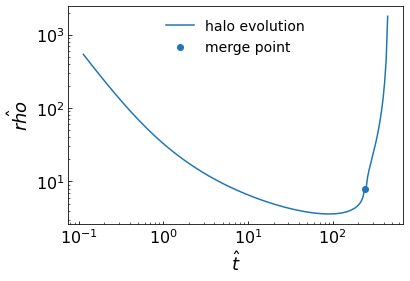

In [7]:
Ncore = 50 # number of cpu used

# compute the evolutionary track of an SIDM halo (rhodm0_hat vs t_hat)
# use pr.stitchSIDMcore_given_pmerge
def worker(num):
    product = product_array[num]
    # compute r1
    if product < product_merge:
        r1,rho1,M1 = pr.r1(halo_init,sigmamx=1,tage=product,disk=disk)
    else:
        product_mirror = 2*product_merge - product
        r1,rho1,M1 = pr.r1(halo_init,sigmamx=1,tage=product_mirror,disk=disk)
    # compute rhodm0
    rhodm0,_,_,_,_,_,_,delta2 = pr.stitchSIDMcore_given_pmerge(r1,rho1,M1,halo_init,disk,product,product_merge,rhodm0_merge)
    
    # delta2 indicates whether the result is physically valid,
    # results with delta2>1e-5 is rejected
    if delta2 > 1e-5: rhodm0 = np.NaN
    return rhodm0

# multiprocess
pool = Pool(Ncore) 
rhodm0_array = pool.map(worker,range(len(product_array)))
pool.close()
rhodm0_array = np.array(rhodm0_array)

# normalization 
rho_hat_arr = rhodm0_array/rhos
t_hat_arr = product_array*trans

# filter invalid results
mask = rho_hat_arr != np.NaN

# plot
plt.plot(t_hat_arr[mask],rho_hat_arr[mask],label='halo evolution')
plt.scatter(t_merge,rhodm0_merge/rhos,label='merge point')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\hat{t}$')
plt.ylabel(r'$\hat{rho}$')
plt.legend(loc='best',frameon=False)
plt.show()

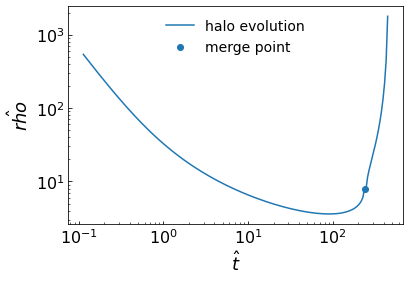

In [ ]:
Ncore = 50 # number of cpu used

# compute the evolutionary track of an SIDM halo (rhodm0_hat vs t_hat)
# use pr.stitchSIDMcore2
def worker(num):
    product = product_array[num]
    # compute r1
    if product < product_merge:
        r1,rho1,M1 = pr.r1(halo_init,sigmamx=1,tage=product,disk=disk)
        sol = pr.stitchSIDMcore2(r1,rho1,M1,halo_init,disk)[0] # use low-density solution
    else:
        product_mirror = 2*product_merge - product
        r1,rho1,M1 = pr.r1(halo_init,sigmamx=1,tage=product_mirror,disk=disk)
        sol1,sol2 = pr.stitchSIDMcore2(r1,rho1,M1,halo_init,disk)[:2]
        sol = sol2 # use high-density solution

        # check if the two solution is identical.
        # If so, the solution not found is probably high-density solution,
        # and the result of high density solution should be considered invalid.
        rhodm0_low,rhodm0_high = sol1[0],sol2[0]
        if np.abs(rhodm0_low/rhodm0_high) < 1e-3: rhodm0 = np.NAN

    # compute rhodm0
    rhodm0,_,_,_,_,_,_,delta2 = sol
    
    # delta2 indicates whether the result is physically valid,
    # results with delta2>1e-5 is rejected
    if delta2 > 1e-5: rhodm0 = np.NaN

    return rhodm0

# multiprocess
pool = Pool(Ncore) 
rhodm0_array = pool.map(worker,range(len(product_array)))
pool.close()
rhodm0_array = np.array(rhodm0_array)

# normalization 
rho_hat_arr = rhodm0_array/rhos
t_hat_arr = product_array*trans

# filter invalid results
mask = rho_hat_arr != np.NaN

# plot
plt.plot(t_hat_arr[mask],rho_hat_arr[mask],label='halo evolution')
plt.scatter(t_merge,rhodm0_merge/rhos,label='merge point')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\hat{t}$')
plt.ylabel(r'$\hat{rho}$')
plt.legend(loc='best',frameon=False)
plt.show()